In [1]:
import clickhouse_connect
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

# Load environment variables
load_dotenv()

# Connect to ClickHouse database using environment variables
client = clickhouse_connect.get_client(
    host=os.getenv("CLICKHOUSE_HOST"),
    port=int(os.getenv("CLICKHOUSE_PORT")),
    username=os.getenv("CLICKHOUSE_USERNAME"),
    password=os.getenv("CLICKHOUSE_PASSWORD"),
)


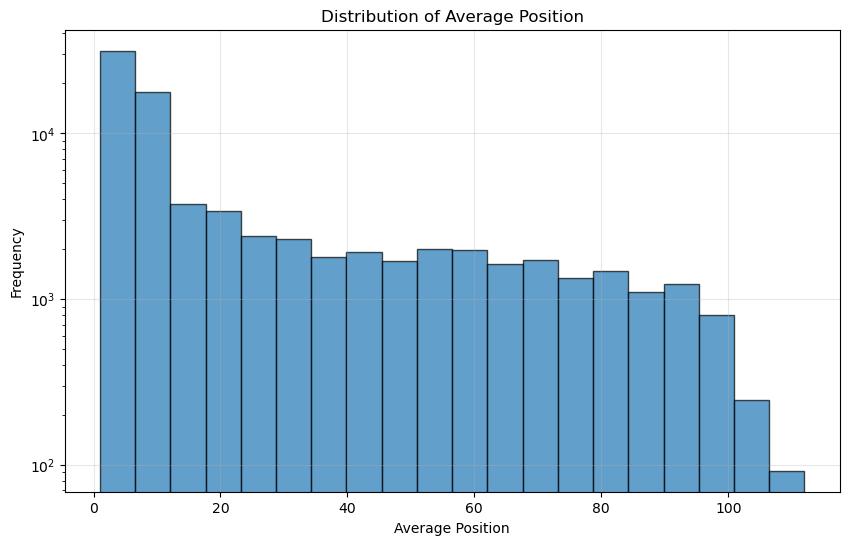

In [ ]:
import pandas as pd

# Query the data
query = "SELECT average_position FROM ahrefs.keywords"
df = client.query_df(query)

# Create the distribution plot
plt.figure(figsize=(10, 6))
plt.hist(
    df["average_position"],
    bins=20,
    alpha=0.7,
    # range=(0.0, 20.0),
    edgecolor="black",
    # log=True,
)
plt.xlabel("Average Position")
plt.ylabel("Frequency")
plt.title("Distribution of Average Position")
plt.grid(True, alpha=0.3)
plt.show()


In [18]:
query = "SELECT keyword, volume, average_position, website FROM ahrefs.keywords"
df = client.query_df(query)


In [20]:
df["keyword"].unique

<bound method Series.unique of 0                 0033 کد کدام کشور است
1        100 تا از بهترین بازیکنان جهان
2                  1001 نام خدا با معنی
3                                 10125
4                       3d printer food
                      ...              
79967                               ۱۴۱
79968                       ۱۹۲.۱۶۸.۱.۱
79969               ۱۹۲.۱۶۸.۱.۱ با گوشی
79970                          ۳۶۰ سپهر
79971                          아웃룩 이모티콘
Name: keyword, Length: 79972, dtype: string>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Query the data
query = "SELECT average_position FROM ahrefs.keywords"
df = client.query_df(query)

data = df["average_position"]  # [df["average_position"]]

# Define exponentially spaced bins
num_bins = 10
bins = np.logspace(0.0, np.log10(data.max()), num_bins)  # 20 bins

# Create histogram with exponential bins
plt.figure(figsize=(10, 6))
plt.hist(data, bins=bins, alpha=0.7, edgecolor="black")

plt.xscale("log")  # Set x-axis to logarithmic
plt.xlabel("Average Position (log scale)")
plt.ylabel("Frequency")
plt.title("Distribution of Average Position")
plt.grid(True, alpha=0.3, which="both")
plt.show()


In [ ]:
from embedding import OllamaEmbedding


embedding = OllamaEmbedding()

In [ ]:
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams
from sentence_transformers import SentenceTransformer

# 1. Connect to Qdrant
client = QdrantClient("http://localhost:6333")

# 2. Load your embedding model
model = SentenceTransformer("MCINext/Hakim")

# 3. Create a collection
client.recreate_collection(
    collection_name="fa_keywords",
    vectors_config=VectorParams(size=768, distance=Distance.COSINE)
)

# 4. Prepare data
texts = [
    "آیفون ۱۶",
    "آیفون ۱۵",
    "هندزفری",
    "گوشی همراه",
    "سامسونگ a54",
    "طلا",
    "نقره"
]
vectors = model.encode(texts).tolist()

# 5. Upload to Qdrant
client.upsert(
    collection_name="fa_keywords",
    points=[
        {"id": i, "vector": vec, "payload": {"text": text}}
        for i, (text, vec) in enumerate(zip(texts, vectors))
    ]
)

# 6. Query
query = "آیفون"
query_vec = model.encode([query])[0].tolist()

results = client.search(
    collection_name="fa_keywords",
    query_vector=query_vec,
    limit=5
)

for r in results:
    print(r.payload["text"], "→", r.score)
